## Création dataframe avec les features

In [2]:
##HOME CREDIT DEFAULT RISK COMPETITION
# La plupart des caractéristiques sont créées en appliquant les fonctions min, max, mean, sum et var aux tableaux groupés.
# Peu de sélection de caractéristiques est effectuée et le surajustement peut être un problème car de nombreuses caractéristiques
#sont liées.
# Les idées clés suivantes ont été utilisées :
    # - Diviser ou soustraire des caractéristiques importantes pour obtenir des taux (comme l'annuité et le revenu).
    # - Dans les données du Bureau : créer des caractéristiques spécifiques pour les crédits actifs et les crédits fermés.
    # - Dans les demandes antérieures : créer des caractéristiques spécifiques pour les demandes approuvées et refusées.
# Modularité : une fonction pour chaque table (sauf bureau_balance et application_test)
# - Encodage unique pour les caractéristiques catégorielles
# Toutes les tables sont jointes à l'application DF à l'aide de la clé SK_ID_CURR (sauf bureau_balance).
# Vous pouvez utiliser LightGBM avec KFold ou KFold stratifié.

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
warnings.simplefilter(action='ignore', category=FutureWarning)
# import lightgbm as lgb
# print(lgb.__version__)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


In [4]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [4]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [5]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

             
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [6]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [7]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    

    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [8]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [9]:
def main(debug = False):
    num_rows = 3000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    
    return df


if __name__ == "__main__":
    submission_file_name = "../notebook/submit.csv"
    with timer("Full model run"):
        final_df = main()
    # print("Final dataframe shape:", final_df.shape)
    # print(final_df)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 30s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 36s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 18s
Installments payments df shape: (339587, 26)
Process installments payments - done in 48s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 26s
Full model run - done in 165s


In [10]:
final_df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 798 entries, index to CC_COUNT
dtypes: float64(622), int64(43), uint8(133)
memory usage: 1.8 GB


In [12]:
#export to csv 
final_df.to_csv("final_df", index=False)

## Echantillon 5000lignes

In [5]:
#import final_df from csv
final_df = pd.read_csv("final_df")

#stratified sampling on final_df dataframe  with 5000 samples
def stratified_sampling(df, n_samples): 
    sample = df.groupby('TARGET', group_keys=False).apply(lambda x: x.sample(int(np.rint(n_samples*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)
    return sample

sample_df = stratified_sampling(final_df, 5000)
sample_df.head()


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,260373,401320,0.0,0,1,0,0,135000.0,343800.0,16155.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,271956,415290,0.0,1,0,0,1,135000.0,545040.0,20677.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,140679,263121,0.0,1,0,0,0,157500.0,677664.0,24471.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,219348,354102,0.0,1,0,0,0,112500.0,473760.0,51151.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,95480,210856,0.0,0,0,0,2,90000.0,675000.0,30631.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4315 entries, 0 to 4314
Columns: 798 entries, index to CC_COUNT
dtypes: float64(622), int64(176)
memory usage: 26.3 MB


In [7]:
sample_df['TARGET'].value_counts()

0.0    3967
1.0     348
Name: TARGET, dtype: int64

## Exploration 

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [17]:
for col in sample_df.columns:
    print(col)

index
SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG

In [18]:
sample_df['TARGET'].value_counts()

0.0    4652
1.0     348
Name: TARGET, dtype: int64

In [19]:
print(sample_df.isna().sum())

index                                                                       0
SK_ID_CURR                                                                  0
TARGET                                                                      0
NAME_CONTRACT_TYPE                                                          0
CODE_GENDER                                                                 0
FLAG_OWN_CAR                                                                0
FLAG_OWN_REALTY                                                             0
CNT_CHILDREN                                                                0
AMT_INCOME_TOTAL                                                            0
AMT_CREDIT                                                                  0
AMT_ANNUITY                                                                 0
AMT_GOODS_PRICE                                                             0
NAME_TYPE_SUITE                                                 

In [20]:
sample_df['NB_NAN']=sample_df.isna().sum(axis=1)

In [21]:
sample_df['NB_NAN'].value_counts()

190    238
172    181
191    166
290    155
192    142
216    136
161    135
160    125
288    124
173    122
174    121
49     109
31      98
142     97
171     86
189     85
143     82
1       79
19      77
193     73
50      69
2       67
147     67
214     65
20      63
162     61
201     60
218     60
258     56
30      56
287     55
199     54
32      54
175     53
144     53
289     48
58      47
215     46
203     46
200     43
159     42
184     38
213     36
259     36
198     35
73      35
169     33
146     33
0       33
453     33
186     31
75      31
48      30
117     30
60      29
3       29
454     28
477     27
18      27
194     26
551     26
21      25
141     24
185     24
51      22
57      21
163     20
176     20
44      20
118     20
72      20
217     19
479     18
29      18
170     18
145     18
202     18
33      17
43      17
187     16
257     14
435     14
476     13
59      13
452     11
455     11
164     11
45      11
46      11
74      10
116     10

In [22]:
sample_df=sample_df.drop_duplicates()

In [23]:
filling_rate = sample_df.notna().mean()
filling_rate_sortvalue= round(filling_rate*100).sort_values(ascending=False)
filling_rate_sortvalue

index                                                                    100.0
AMT_REQ_CREDIT_BUREAU_DAY_Agriculture                                    100.0
FLAG_DOCUMENT_21_Realty agents                                           100.0
FLAG_DOCUMENT_21_Sales staff                                             100.0
FLAG_DOCUMENT_21_Secretaries                                             100.0
FLAG_DOCUMENT_21_Security staff                                          100.0
FLAG_DOCUMENT_21_Waiters/barmen staff                                    100.0
AMT_REQ_CREDIT_BUREAU_HOUR_FRIDAY                                        100.0
AMT_REQ_CREDIT_BUREAU_HOUR_MONDAY                                        100.0
AMT_REQ_CREDIT_BUREAU_HOUR_SATURDAY                                      100.0
AMT_REQ_CREDIT_BUREAU_HOUR_SUNDAY                                        100.0
AMT_REQ_CREDIT_BUREAU_HOUR_THURSDAY                                      100.0
AMT_REQ_CREDIT_BUREAU_HOUR_TUESDAY                  

In [24]:
sample_df.describe()

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12_Cash loans,FLAG_DOCUMENT_12_Revolving loans,FLAG_DOCUMENT_13_F,FLAG_DOCUMENT_13_M,FLAG_DOCUMENT_14_N,FLAG_DOCUMENT_14_Y,FLAG_DOCUMENT_15_N,FLAG_DOCUMENT_15_Y,FLAG_DOCUMENT_16_Children,FLAG_DOCUMENT_16_Family,FLAG_DOCUMENT_16_Group of people,FLAG_DOCUMENT_16_Other_A,FLAG_DOCUMENT_16_Other_B,"FLAG_DOCUMENT_16_Spouse, partner",FLAG_DOCUMENT_16_Unaccompanied,FLAG_DOCUMENT_17_Businessman,FLAG_DOCUMENT_17_Commercial associate,FLAG_DOCUMENT_17_Maternity leave,FLAG_DOCUMENT_17_Pensioner,FLAG_DOCUMENT_17_State servant,FLAG_DOCUMENT_17_Student,FLAG_DOCUMENT_17_Unemployed,FLAG_DOCUMENT_17_Working,FLAG_DOCUMENT_18_Academic degree,FLAG_DOCUMENT_18_Higher education,FLAG_DOCUMENT_18_Incomplete higher,FLAG_DOCUMENT_18_Lower secondary,FLAG_DOCUMENT_18_Secondary / secondary special,FLAG_DOCUMENT_19_Civil marriage,FLAG_DOCUMENT_19_Married,FLAG_DOCUMENT_19_Separated,FLAG_DOCUMENT_19_Single / not married,FLAG_DOCUMENT_19_Unknown,FLAG_DOCUMENT_19_Widow,FLAG_DOCUMENT_20_Co-op apartment,FLAG_DOCUMENT_20_House / apartment,FLAG_DOCUMENT_20_Municipal apartment,FLAG_DOCUMENT_20_Office apartment,FLAG_DOCUMENT_20_Rented apartment,FLAG_DOCUMENT_20_With parents,FLAG_DOCUMENT_21_Accountants,FLAG_DOCUMENT_21_Cleaning staff,FLAG_DOCUMENT_21_Cooking staff,FLAG_DOCUMENT_21_Core staff,FLAG_DOCUMENT_21_Drivers,FLAG_DOCUMENT_21_HR staff,FLAG_DOCUMENT_21_High skill tech staff,FLAG_DOCUMENT_21_IT staff,FLAG_DOCUMENT_21_Laborers,FLAG_DOCUMENT_21_Low-skill Laborers,FLAG_DOCUMENT_21_Managers,FLAG_DOCUMENT_21_Medicine staff,FLAG_DOCUMENT_21_Private service staff,FLAG_DOCUMENT_21_Realty agents,FLAG_DOCUMENT_21_Sales staff,FLAG_DOCUMENT_21_Secretaries,FLAG_DOCUMENT_21_Security staff,FLAG_DOCUMENT_21_Waiters/barmen staff,AMT_REQ_CREDIT_BUREAU_HOUR_FRIDAY,AMT_REQ_CREDIT_BUREAU_HOUR_MONDAY,AMT_REQ_CREDIT_BUREAU_HOUR_SATURDAY,AMT_REQ_CREDIT_BUREAU_HOUR_SUNDAY,AMT_REQ_CREDIT_BUREAU_HOUR_THURSDAY,AMT_REQ_CREDIT_BUREAU_HOUR_TUESDAY,AMT_REQ_CREDIT_BUREAU_HOUR_WEDNESDAY,AMT_REQ_CREDIT_BUREAU_DAY_Advertising,AMT_REQ_CREDIT_BUREAU_DAY_Agriculture,AMT_REQ_CREDIT_BUREAU_DAY_Bank,AMT_REQ_CREDIT_BUREAU_DAY_Business Entity Type 1,

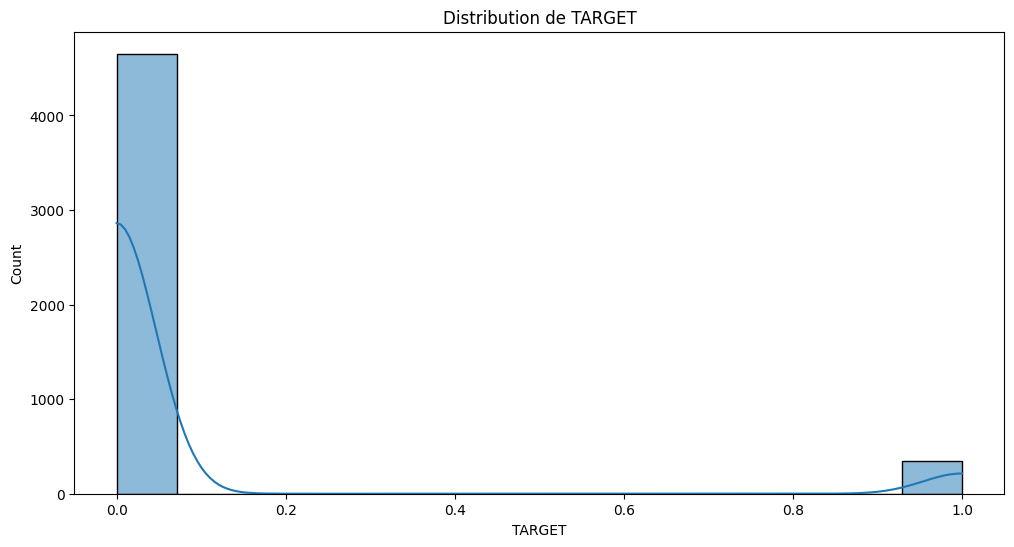

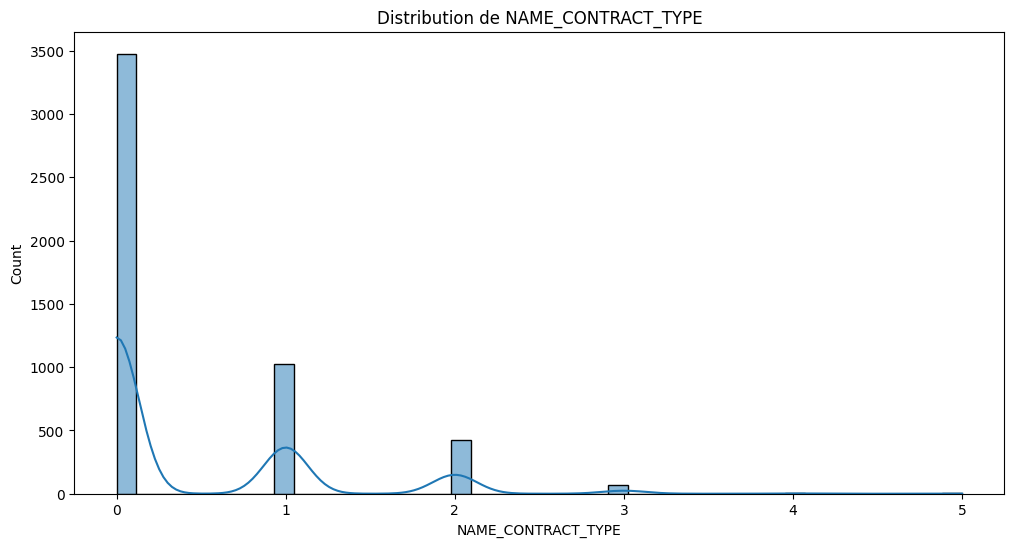

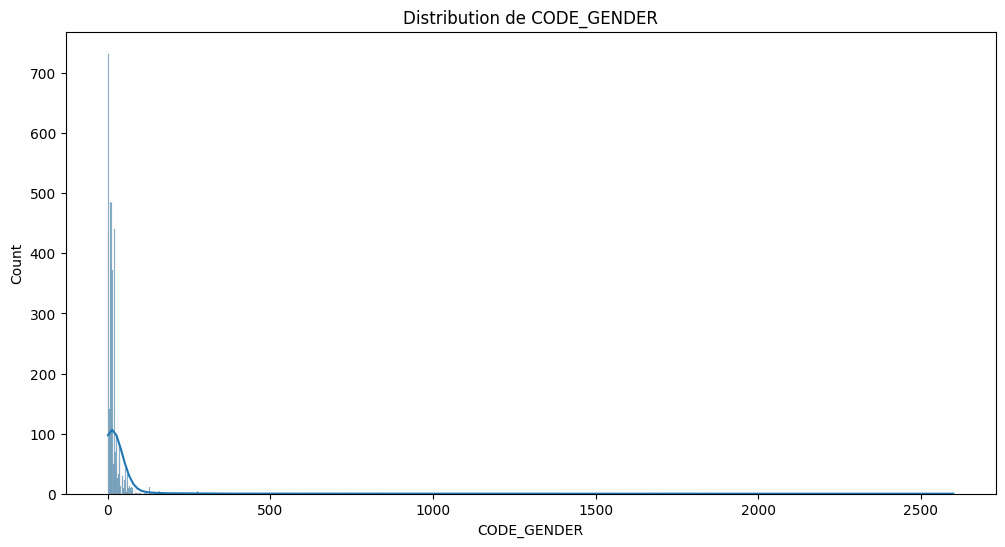

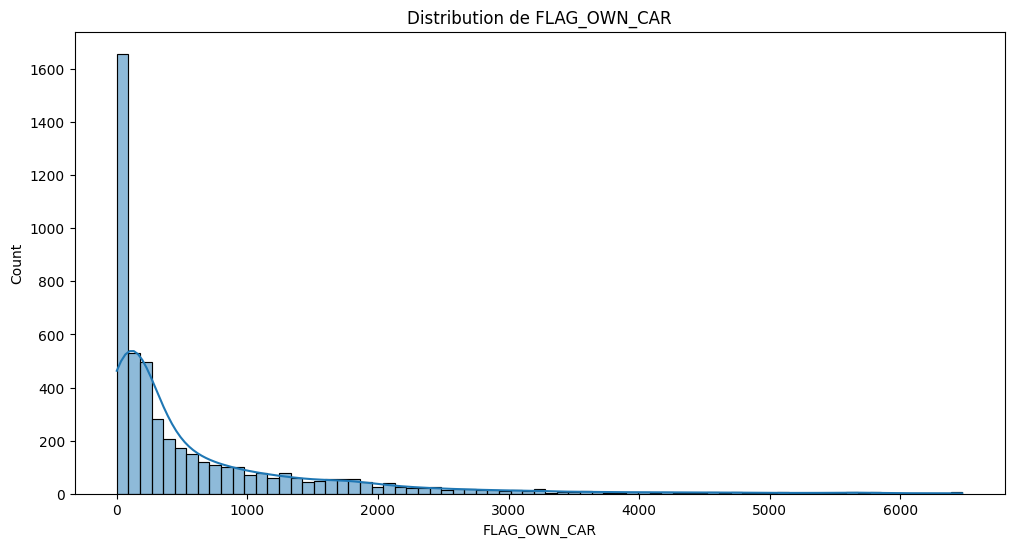

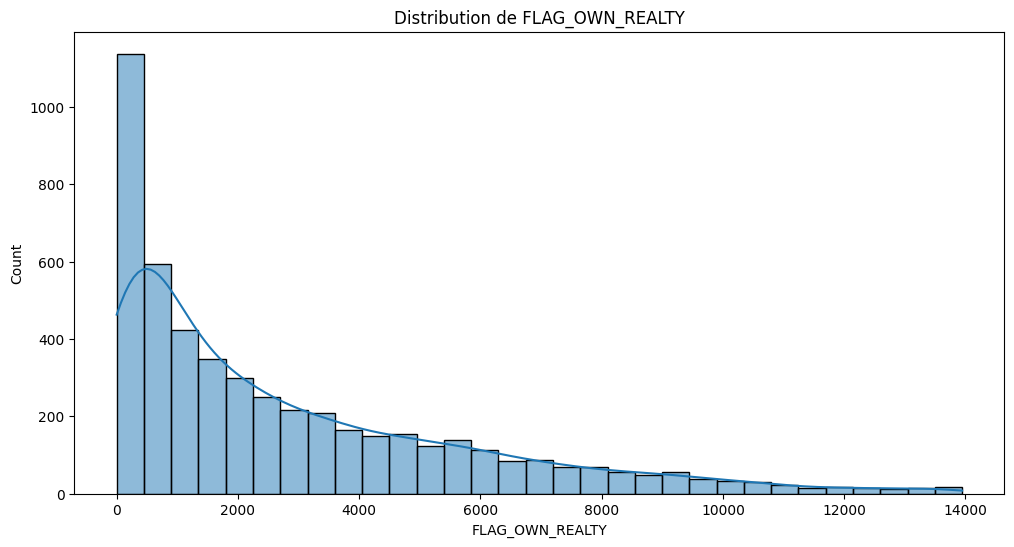

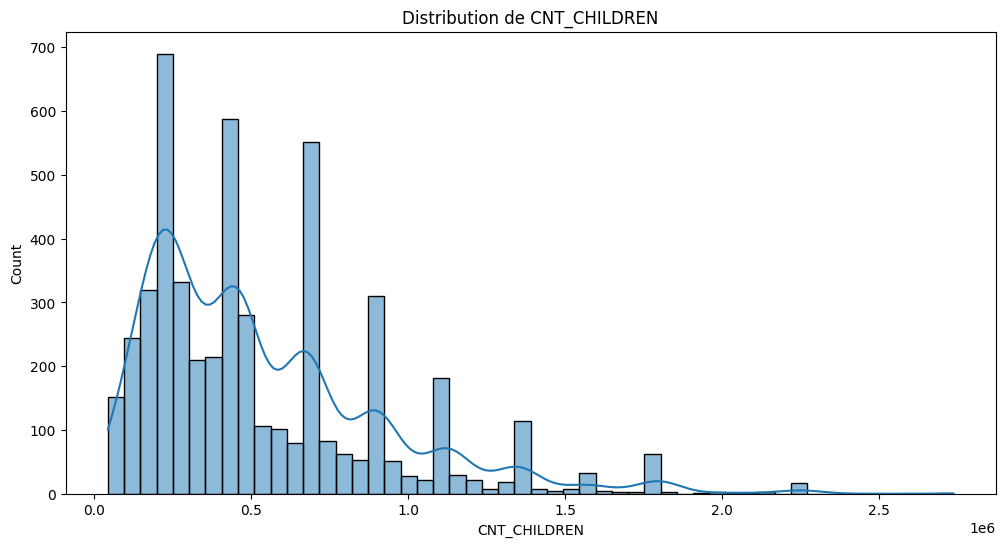

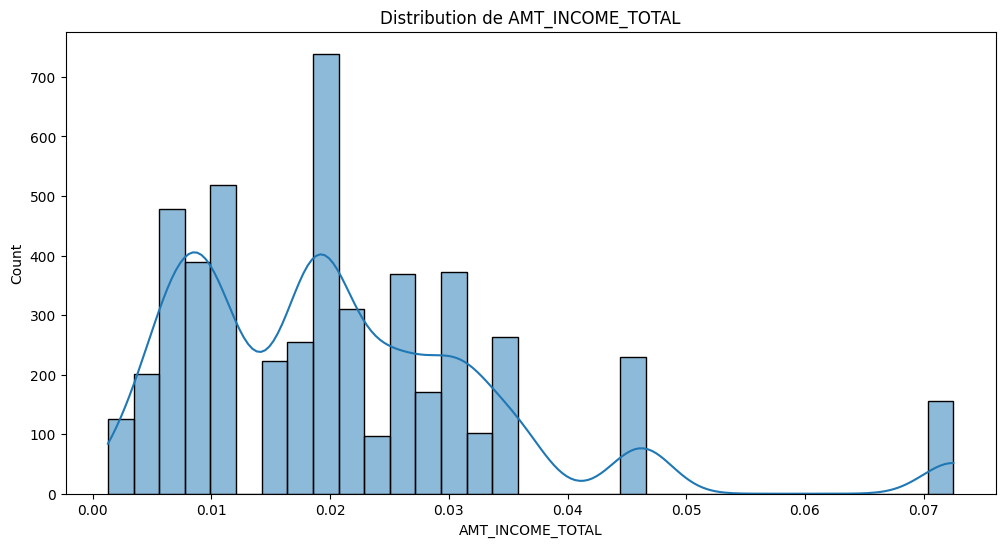

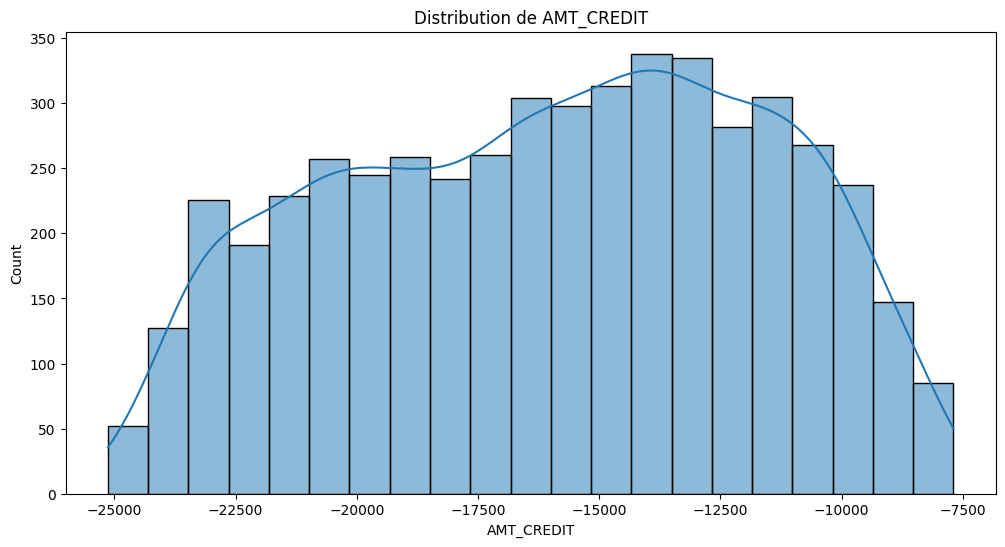

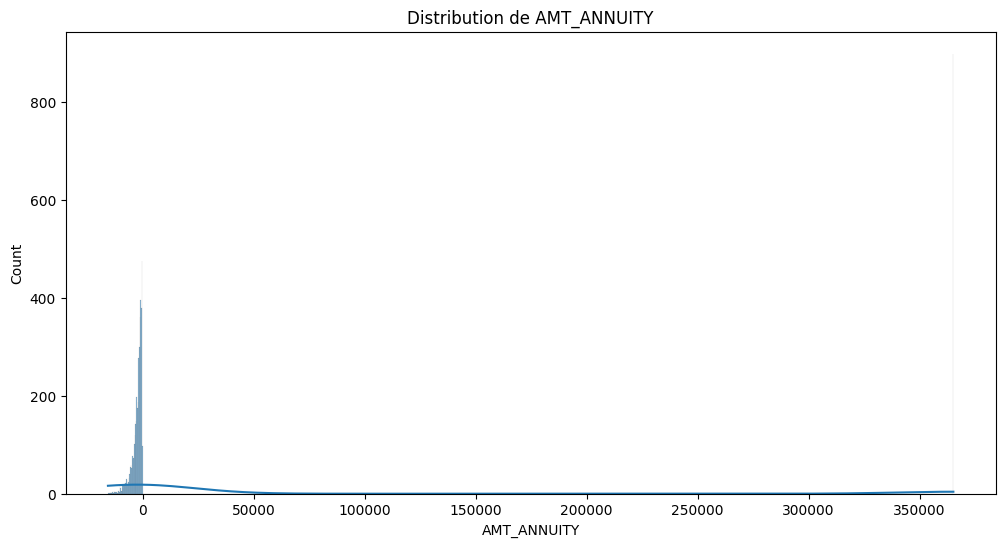

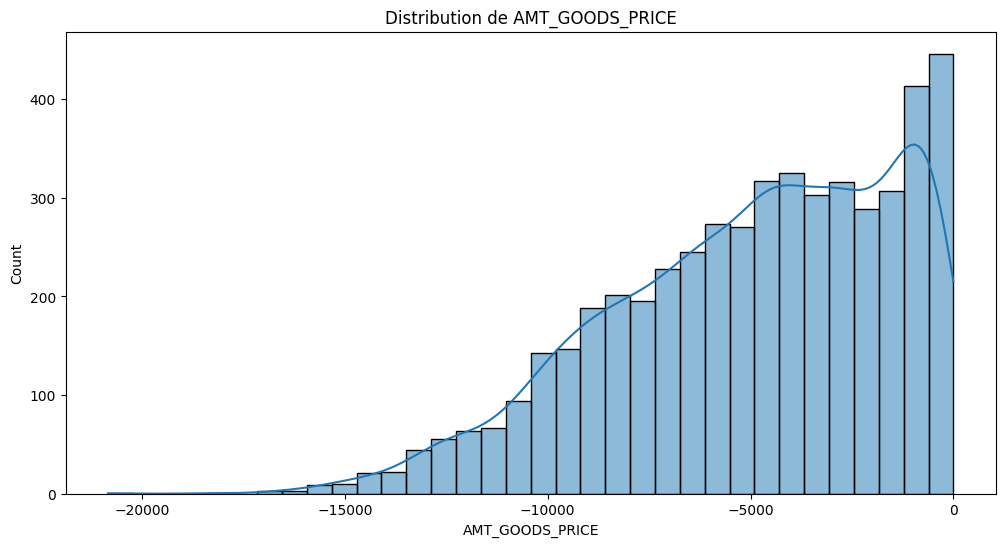

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner les premières 5 colonnes pour l'exemple
selected_columns = sample_df.columns[2:12]

# Tracer des histogrammes pour ces colonnes
for col in selected_columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=sample_df, x=col, kde=True)
    plt.title('Distribution de ' + col)
    plt.show()

## Preprocessing sample_df: scaling

In [8]:
### METTRE DANS LA PIPELINE - A FAIRE
#remplacer les valeurs infinies par des NaN
sample_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#sépare la cible du reste des données
X = sample_df.drop(columns=["TARGET"])
y = sample_df['TARGET']
print(f"shape de X : {X.shape}")
print(f"shape de y : {y.shape}")

# Remplacement des valeurs manquantes par le mode (la valeur la plus fréquente)
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# Standardisation des caractéristiques
# Cela pourrait être utile pour certains modèles qui sont sensibles aux valeurs abbérantes
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)

# on construit les échantillons d'apprentissage et de validation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=42, stratify=y)#stratify to preserve the proportion of target as in the original dataset



shape de X : (4315, 797)
shape de y : (4315,)


In [9]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)
print(X_train_df.isnull().sum())

index                               0
SK_ID_CURR                          0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
                                   ..
CC_NAME_CONTRACT_STATUS_nan_MAX     0
CC_NAME_CONTRACT_STATUS_nan_MEAN    0
CC_NAME_CONTRACT_STATUS_nan_SUM     0
CC_NAME_CONTRACT_STATUS_nan_VAR     0
CC_COUNT                            0
Length: 797, dtype: int64


## Pipeline to search best model

## Pipeline 1

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, learning_curve, validation_curve

# Créez vos pipelines
pipe_lr = Pipeline([('clf', LogisticRegression())])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier())])
pipe_rf = Pipeline([('clf', RandomForestClassifier())])
pipe_svm = Pipeline([('clf', SVC())])

# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
                   'clf__C': param_range_fl,
                   'clf__solver': ['liblinear']}] 

grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
                   'clf__min_samples_leaf': param_range,
                   'clf__max_depth': param_range,
                   'clf__min_samples_split': param_range[1:]}]

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
                   'clf__min_samples_leaf': param_range,
                   'clf__max_depth': param_range,
                   'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
                    'clf__C': param_range}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
                     param_grid=grid_params_lr,
                     scoring='roc_auc',
                     cv=10) 

gs_dt = GridSearchCV(estimator=pipe_dt,
                     param_grid=grid_params_dt,
                     scoring='roc_auc',
                     cv=10,
                     n_jobs=jobs)

gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=grid_params_rf,
                     scoring='roc_auc',
                     cv=10, 
                     n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
                      param_grid=grid_params_svm,
                      scoring='roc_auc',
                      cv=10,
                      n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_dt, gs_rf, gs_svm]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Random Forest', 3: 'Support Vector Machine'}

# Fit the grid search objects
print('Performing model optimizations...')
best_auc = 0.0
best_clf = 0
best_gs = ''

for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])	
    gs.fit(X_train, y_train)
    print('Best params: %s' % gs.best_params_)
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred_proba = gs.predict_proba(X_test)[:, 1]
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % roc_auc_score(y_test, y_pred_proba))
    # Track best (highest test accuracy) model
    if roc_auc_score(y_test, y_pred_proba) > best_auc:
        best_auc = roc_auc_score(y_test, y_pred_proba)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set AUC: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Logistic Regression


c:\Users\dalila.derdar.ONCEFORALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\dalila.derdar.ONCEFORALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\dalila.derdar.ONCEFORALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\dalila.derdar.ONCEFORALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\dalila.derdar.ONCEFORALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:124

Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.673
Test set accuracy score for best params: 0.701 

Estimator: Decision Tree
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5}
Best training accuracy: 0.628
Test set accuracy score for best params: 0.521 

Estimator: Random Forest
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 7, 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 9}
Best training accuracy: 0.721
Test set accuracy score for best params: 0.689 

Estimator: Support Vector Machine


## Pipeline 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from time import time

# Initialize classifiers
logreg = LogisticRegression(random_state=42)
tree = DecisionTreeClassifier(random_state=42)
forest = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42, probability=True)

# Define the hyperparameters
hyperparameters = {
    logreg: {
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear']
    },
    tree: {
        'criterion': ['gini', 'entropy'],
        'max_depth': range(1, 10),
        'min_samples_split': range(2, 10),
        'min_samples_leaf': range(1, 10)
    },
    forest: {
        'n_estimators': range(10, 101, 10),
        'criterion': ['gini', 'entropy'],
        'max_depth': range(1, 10),
        'min_samples_split': range(2, 10),
        'min_samples_leaf': range(1, 10)
    },
    svm: {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
}

# Initialize the DataFrame for storing the results
results = []

# Loop through the classifiers
for classifier, params in hyperparameters.items():
    start = time()
    classifier_name = classifier.__class__.__name__
    
    gs = RandomizedSearchCV(classifier, params, scoring='roc_auc', cv=5, n_iter=10, n_jobs=-1, random_state=42)
    gs.fit(X_train, y_train)
    
    # Predict the target for the testing data
    y_pred = gs.predict(X_test)
    
    # Calculate the metrics
    auc = roc_auc_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store the results in a DataFrame
    results.append({
        'Model': classifier_name,
        'Best Parameters': gs.best_params_,
        'Execution Time (s)': time() - start,
        'Training AUC': gs.best_score_,
        'Testing AUC': auc,
        'Testing Accuracy': acc,
        'Testing F1 Score': f1
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df


c:\Users\dalila.derdar.ONCEFORALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Pipeline 3

### Pipeline 3.1 : tous les modèles avec paramètres par défaut 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import time

# Initialize the classifiers
clf1 = LogisticRegression(random_state=42)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = RandomForestClassifier(random_state=42)
clf4 = SVC(random_state=42, probability=True)
clf5 = KNeighborsClassifier()

# Initialize the hyperparameters for each dictionary
param1 = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'clf__penalty': ['l2'], 'clf': [clf1]}
param2 = {'clf__max_depth': [None, 5, 10, 15, 20], 'clf__min_samples_split': [2, 5, 10], 'clf': [clf2]}
param3 = {'clf__n_estimators': [10, 50, 100, 200], 'clf__max_depth': [None, 5, 10, 15, 20], 'clf': [clf3]}
param4 = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'clf__gamma': ['scale', 'auto'], 'clf': [clf4]}
param5 = {'clf__n_neighbors': [3, 5, 7, 9, 11], 'clf': [clf5]}

## rajouter ici les preprocessing

# Create a pipeline
pipeline = Pipeline([('clf', clf1)])
params = [param1, param2, param3, param4, param5]

#Demander de calculer d'autres métrics sur le valide set
scorings = ['roc_auc', 'precision', 'recall', 'f1']

# Use RandomizedSearchCV to find the best parameters
gs = RandomizedSearchCV(pipeline, params, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring=scorings,refit='roc_auc', return_train_score=True)

start = time.time()

# Fit the model
gs.fit(X_train, y_train)

print("Execution time: " + str((time.time() - start)) + ' ms')
print()
print("Best parameters: ", gs.best_params_)
print()
print("Best training AUC: ", gs.best_score_)
print()
# Predict the labels of the test set
y_pred = gs.predict(X_test)

# Calculate the probabilities for the test set
y_pred_proba = gs.predict_proba(X_test)[:, 1]

# Compute the AUC score, precision, recall, and F1 score
auc_test = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store the results in a DataFrame
results = pd.DataFrame({
    'Model': [gs.best_params_['clf'].__class__.__name__],
    'Best Parameters': [gs.best_params_],
    'Training AUC': [gs.best_score_],
    'Test AUC': [auc_test],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

print(results)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Execution time: 352.74126839637756 ms

Best parameters:  {'clf__n_estimators': 100, 'clf__max_depth': 20, 'clf': RandomForestClassifier(max_depth=20, random_state=42)}

Best training AUC:  0.6817312086060937

                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'clf__n_estimators': 100, 'clf__max_depth': 2...   

   Training AUC  Test AUC  Precision  Recall  F1 Score  
0      0.681731  0.642857        0.0     0.0       0.0  


c:\Users\dalila.derdar.ONCEFORALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
cm_1 = confusion_matrix(y_test, y_pred)
cm_1

array([[793,   0],
       [ 70,   0]], dtype=int64)

In [20]:
results 

,Model,Best Parameters,Training AUC,Test AUC,Precision,Recall,F1 Score
0,RandomForestClassifier,"{'clf__n_estimators': 100, 'clf__max_depth': 2...",0.681731,0.642857,0.0,0.0,0.0


### Pipeline 3-2 recherche des meilleurs hyerparamètres sur le meilleur modèle randomforest

In [23]:
#Réentrainer avec plus d'hyperparamètres de Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameters
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'class_weight': ['balanced', None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=5, n_jobs=-1, scoring= scorings, refit= 'roc_auc')

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", random_search.best_params_)

# Predict the labels of the test set
y_pred = random_search.predict(X_test)

# Evaluate on the test set
y_pred_proba = random_search.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store the results in a DataFrame
results = pd.DataFrame({
    'Model': [random_search.best_estimator_.__class__.__name__],
    'Best Parameters': [random_search.best_params_],
    'Training AUC': [random_search.best_score_],
    'Test AUC': [auc],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

print(results)


Best parameters:  {'class_weight': None, 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 143}
                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'class_weight': None, 'max_depth': 8, 'max_fe...   

   Training AUC  Test AUC  Precision  Recall  F1 Score  
0      0.720484  0.715799        0.0     0.0       0.0  


In [24]:
#afficher la matrice de confusion pour le meilleur modèle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[792   1]
 [ 70   0]]


### Pipeline 3-3 modification des hyperparamètres du meilleur modèle randomforest

In [16]:
#Réentrainer avec changement de seuil de décision à 0.3
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameters
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'class_weight': ['balanced', None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=5, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", random_search.best_params_)

# Predict the labels of the test set with a different threshold
y_pred_proba = random_search.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.3).astype(int)

# Evaluate on the test set
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store the results in a DataFrame
results = pd.DataFrame({
    'Model': [random_search.best_estimator_.__class__.__name__],
    'Best Parameters': [random_search.best_params_],
    'Training AUC': [random_search.best_score_],##ce n'est pas le score train score mais le score de validation. Plutôt faire y_train_pred = random_search.predict(X_train) 
    'Test AUC': [auc],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

print(results)


Best parameters:  {'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 9, 'n_estimators': 148}
                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'class_weight': None, 'max_depth': 10, 'max_f...   

   Training AUC  Test AUC  Precision    Recall  F1 Score  
0      0.919758   0.71207     0.3125  0.071429  0.116279  


Le score d'AUC pour le jeu d'entraînement est de 0.92, ce qui indique que le modèle est capable de distinguer efficacement les remboursements des non-remboursements sur le jeu de données d'entraînement. Cependant, le score d'AUC pour le jeu de test est de 0.71, ce qui est significativement plus bas. Cela peut indiquer que le modèle surapprend sur le jeu de données d'entraînement (overfitting) et ne généralise pas bien aux nouvelles données.

La précision est de 0.31, ce qui signifie que seulement 31% des prêts que le modèle prédit comme étant en défaut (1 = ne peut pas rembourser) sont effectivement en défaut. En d'autres termes, beaucoup de prêts qui auraient pu être remboursés sont refusés par le modèle.

Le recall est de 0.071, ce qui signifie que le modèle est seulement capable de détecter environ 7.1% des défauts de remboursement. En d'autres termes, le modèle laisse passer environ 93% des défauts de remboursement, ce qui est très problématique car cela signifie que beaucoup de prêts qui ne seront pas remboursés sont accordés.

Le score F1 est une moyenne harmonique de la précision et du rappel, et il est généralement plus utile que la précision lorsque vous avez une répartition inégale des classes (c'est-à-dire beaucoup plus de remboursements que de défauts de remboursement). Un score F1 de 0.116 est assez faible, ce qui indique que le modèle ne parvient pas à trouver un bon équilibre entre précision et rappel.

ces résultats suggèrent que votre modèle a du mal à identifier les défauts de remboursement, et il est probablement trop prudent en refusant beaucoup de prêts qui seraient effectivement remboursés. Cela pourrait être dû à une sous-représentation des défauts de remboursement dans les données, ou à un seuil de décision qui est trop élevé.

Essayer le rééquilibrage des classes